In [27]:

#Importing all the relevant library
%matplotlib inline
import h5py, os
#from functions import transforms as T
#from functions.subsample import MaskFunc
from scipy.io import loadmat
from torch.utils.data import DataLoader
import numpy as np
import torch
from matplotlib import pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as T
import glob
#from functions import transforms as T 
#from functions.subsample import MaskFunc
from PIL import Image
import random
from numpy.fft import fftshift, ifftshift, fftn, ifftn
import cmath

In [28]:
import torchvision.transforms as transforms

In [29]:
import numpy as np
import torch


class MaskFunc:
    """
    MaskFunc creates a sub-sampling mask of a given shape.

    The mask selects a subset of columns from the input k-space data. If the k-space data has N
    columns, the mask picks out:
        1. N_low_freqs = (N * center_fraction) columns in the center corresponding to
           low-frequencies
        2. The other columns are selected uniformly at random with a probability equal to:
           prob = (N / acceleration - N_low_freqs) / (N - N_low_freqs).
    This ensures that the expected number of columns selected is equal to (N / acceleration)

    It is possible to use multiple center_fractions and accelerations, in which case one possible
    (center_fraction, acceleration) is chosen uniformly at random each time the MaskFunc object is
    called.

    For example, if accelerations = [4, 8] and center_fractions = [0.08, 0.04], then there
    is a 50% probability that 4-fold acceleration with 8% center fraction is selected and a 50%
    probability that 8-fold acceleration with 4% center fraction is selected.
    """

    def __init__(self, center_fractions, accelerations):
        """
        Args:
            center_fractions (List[float]): Fraction of low-frequency columns to be retained.
                If multiple values are provided, then one of these numbers is chosen uniformly
                each time.

            accelerations (List[int]): Amount of under-sampling. This should have the same length
                as center_fractions. If multiple values are provided, then one of these is chosen
                uniformly each time. An acceleration of 4 retains 25% of the columns, but they may
                not be spaced evenly.
        """
        if len(center_fractions) != len(accelerations):
            raise ValueError('Number of center fractions should match number of accelerations')

        self.center_fractions = center_fractions
        self.accelerations = accelerations
        self.rng = np.random.RandomState()

    def __call__(self, shape, seed=None):
        """
        Args:
            shape (iterable[int]): The shape of the mask to be created. The shape should have
                at least 3 dimensions. Samples are drawn along the second last dimension.
            seed (int, optional): Seed for the random number generator. Setting the seed
                ensures the same mask is generated each time for the same shape.
        Returns:
            torch.Tensor: A mask of the specified shape.
        """
        if len(shape) < 3:
            raise ValueError('Shape should have 3 or more dimensions')

        self.rng.seed(seed)
        num_cols = shape[-2]

        choice = self.rng.randint(0, len(self.accelerations))
        center_fraction = self.center_fractions[choice]
        acceleration = self.accelerations[choice]

        # Create the mask
        num_low_freqs = int(round(num_cols * center_fraction))
        prob = (num_cols / acceleration - num_low_freqs) / (num_cols - num_low_freqs)
        mask = self.rng.uniform(size=num_cols) < prob
        pad = (num_cols - num_low_freqs + 1) // 2
        mask[pad:pad + num_low_freqs] = True

        # Reshape the mask
        mask_shape = [1 for _ in shape]
        mask_shape[-2] = num_cols
        mask = torch.from_numpy(mask.reshape(*mask_shape).astype(np.float32))

        return mask



In [30]:
import numpy as np
from numpy.fft import fftshift, ifftshift, fftn, ifftn

def transform_kspace_to_image(k, dim=None, img_shape=None):
    """ Computes the Fourier transform from k-space to image space
    along a given or all dimensions
    :param k: k-space data
    :param dim: vector of dimensions to transform
    :param img_shape: desired shape of output image
    :returns: data in image space (along transformed dimensions)
    """
    if not dim:
        dim = range(k.ndim)

    img = fftshift(ifftn(ifftshift(k, axes=dim), s=img_shape, axes=dim), axes=dim)
    #img = fftshift(ifft2(ifftshift(k, dim=dim)), dim=dim)
    img *= np.sqrt(np.prod(np.take(img.shape, dim)))
    return img


def transform_image_to_kspace(img, dim=None, k_shape=None):
    """ Computes the Fourier transform from image space to k-space space
    along a given or all dimensions
    :param img: image space data
    :param dim: vector of dimensions to transform
    :param k_shape: desired shape of output k-space data
    :returns: data in k-space (along transformed dimensions)
    """
    if not dim:
        dim = range(img.ndim)

    k = fftshift(fftn(ifftshift(img, axes=dim), s=k_shape, axes=dim), axes=dim)
    #k = fftshift(fft2(ifftshift(img, dim=dim)), dim=dim)
    k /= np.sqrt(np.prod(np.take(img.shape, dim)))
    return k

In [31]:

import numpy as np
from PIL import Image
import random
from IPython.display import display


def add_noise(array: np.ndarray, dropout_rate: float = 0.10) -> np.ndarray:
    """
    This function adds noise
    :param array:
    :param dropout_rate: percent of pixels to be dropped
    :return:
    """
   # assert len(array.shape) == 4
   # assert array.shape[1] == 3

    channels = array.shape[1]
    height = array.shape[2]
    width = array.shape[3]

    total_pixels = height * width
    queued_pixels = int(total_pixels * dropout_rate)

    filled_pixels = 0
    while filled_pixels < queued_pixels:
        d_h = random.randint(1, 3)
        d_w = random.randint(1, 3)
        filled_pixels += d_h * d_w
        h = random.randint(0, height - d_h)
        w = random.randint(0, width - d_w)

        # now overwrite selected pixels with random dark color
        array[:, :, h:h+d_h, w:w+d_w] = random.randint(1, 25) / 255.0

    return array


def array_to_image(array: np.ndarray):
    """
    This function converts NumPy array to image
    :param array:
    :return:
    """
    assert len(array.shape) == 4
    assert array.shape[1] == 1 or array.shape[1] == 3

    scaled = (array * 255.0).astype(np.uint8)
    if array.shape[1] == 1:
        reshaped = scaled.reshape((array.shape[2], array.shape[3]))
        return Image.fromarray(reshaped,"L")
    else:
        reshaped = scaled.reshape((3, array.shape[2], array.shape[3])).transpose([1, 2, 0])
        return Image.fromarray(reshaped,"RGB")


def image_to_array(image) -> np.ndarray:
    """
    This function converts image to NumPy array
    :param image:
    :return:
    """
    image1 = np.array(image)
    return np.expand_dims(np.asarray(image1), 0).astype(np.float) / 255.0







In [32]:

def show_slices(data, slice_nums, cmap=None): # visualisation
    fig = plt.figure(figsize=(15,10))
    for i, num in enumerate(slice_nums):
        plt.subplot(1, len(slice_nums), i + 1)
        plt.imshow(data[num], cmap=cmap)
        plt.axis('off')

In [33]:
class MRIDataset(DataLoader):
    def __init__(self, data_list):
        self.data_list = data_list

    def __len__(self):
        return len(self.data_list)

    def __getitem__(self, idx):
        subject_id = self.data_list[idx]

        return get_epoch_batch(subject_id)

In [34]:
import random
import numpy as np
from numpy.fft import fftshift, ifftshift, fftn, ifftn
import cmath
def noise_and_kspace(image):
    #change to k-space
    img_fft = fftshift(fftn(image))
    size_img = img_fft.shape
     #np.random.uniform, np.random.normal
    std = np.random.normal(0.000, 0.005) * np.amax(img_fft)
    noise = fftshift(std * np.random.standard_normal(size_img) + std * 1j * np.random.standard_normal(size_img));     #This generates a complex noise signal.
    img_fft_noise = img_fft + noise # k-space
    img_noise = ifftn(ifftshift(img_fft_noise))# revert k-space back to noise
    return img_fft, img_fft_noise, img_noise

In [42]:
def get_epoch_batch(subject_id):
    ''' random select a few slices (batch_size) from each volume'''

    fname, rawdata_name = subject_id  
    
#    with h5py.File(rawdata_name, 'r') as data:
#        rawdata = data['kspace'][slice]
   
    im_frame = Image.open(rawdata_name)
    im_fft, im_fft_noise, noise_im_frame = noise_and_kspace(im_frame)

    ############################
    #img_und = to_tensor(np.array(noise_im_frame)).unsqueeze(0) # noise image tensor form    
    preprocess = T.Compose([
                       # T.Grayscale(num_output_channels=1),
                           T.Resize(64),    #128 as maximum #64
                           T.CenterCrop(64),
                           T.ToTensor() #,
                            ])
    img_gt = preprocess(Image.fromarray(np.uint8(im_fft)).convert('L'))
    img_und = preprocess(Image.fromarray(np.uint8(im_fft_noise)).convert('L'))
    
    n1 = (img_und**2).sum(dim=-1).sqrt()
    norm = n1.max() 
    if norm < 1e-6: norm = 1e-6
    
    img_gt, img_und = img_gt/norm , img_und/norm

    return img_gt.squeeze(0), img_und.squeeze(0)

In [43]:
def load_data_path(train_data_path, val_data_path):
    """ Go through each subset (training, validation) and list all 
    the file names, the file paths and the slices of subjects in the training and validation sets 
    """

    data_list = {}
    train_and_val = ['train', 'val']
    data_path = [train_data_path, val_data_path]
      
    for i in range(len(data_path)):

        data_list[train_and_val[i]] = []
        
        which_data_path = data_path[i]
        tr = 0
        te = 0
        alfa = 0
    
        for fname in sorted(os.listdir(which_data_path + '/images')):
            if fname == '.DS_Store': continue
            
            subject_data_path = os.path.join(which_data_path + '/images', fname)
                     
            if not os.path.isfile(subject_data_path): continue 
            
     
            #get information from text file
            # this will return a tuple of root and extension
            split_tup = os.path.splitext(fname)

  
            # extract the file name and extension
            file_name = split_tup[0]
  
  
            data_list[train_and_val[i]].append((fname, subject_data_path))
    
    return data_list

# The initial model, based on the AlexNet architecture

# RestNet

In [44]:
class baseBlock(torch.nn.Module):
    expansion = 1
    def __init__(self,input_planes,planes,stride=1,dim_change=None):
        super(baseBlock,self).__init__()
        #declare convolutional layers with batch norms
        self.conv1 = torch.nn.Conv2d(input_planes,planes,stride=stride,kernel_size=3,padding=1)
        self.bn1   = torch.nn.BatchNorm2d(planes)
        self.conv2 = torch.nn.Conv2d(planes,planes,stride=1,kernel_size=3,padding=1)
        self.bn2   = torch.nn.BatchNorm2d(planes)
        self.dim_change = dim_change
    def forward(self,x):
        #Save the residue
        res = x
        output = F.relu(self.bn1(self.conv1(x)))
        output = self.bn2(self.conv2(output))
        if self.dim_change is not None:
            res = self.dim_change(res)
        
        output += res
        output = F.relu(output)

        return output

class ResNet(torch.nn.Module):
    def __init__(self,block,num_layers,classes=10):
        super(ResNet,self).__init__()
        #according to research paper:
        self.input_planes = 64 #256
        self.conv1 = torch.nn.Conv2d(1,64,kernel_size=3,stride=1,padding=1)
        self.layer1 = self._layer(block,64,num_layers[0],stride=1)
        self.layer2 = self._layer(block,64,num_layers[1],stride=1)
        self.layer3 = self._layer(block,64,num_layers[2],stride=1)
        self.layer4 = self._layer(block,64,num_layers[3],stride=1)
        self.layer5 = self._layer(block,64,num_layers[3],stride=1)
        self.layer6 = self._layer(block,64,num_layers[3],stride=1)
        self.layer7 = self._layer(block,64,num_layers[3],stride=1)
        self.layer8 = self._layer(block,64,num_layers[2],stride=1)
        self.layer9 = self._layer(block,64,num_layers[3],stride=1)
        self.layer10 = self._layer(block,64,num_layers[3],stride=1)
        self.layer11 = self._layer(block,64,num_layers[3],stride=1)
        self.layer12 = self._layer(block,64,num_layers[3],stride=1)
        self.layer13 = self._layer(block,64,num_layers[3],stride=1)
        self.layer14 = self._layer(block,64,num_layers[3],stride=1)
        self.layer15 = self._layer(block,64,num_layers[3],stride=1)
        self.layer16 = self._layer(block,64,num_layers[3],stride=1)
        self.layer17 = self._layer(block,64,num_layers[3],stride=1)
        self.layer18 = self._layer(block,64,num_layers[3],stride=1)
        self.conv2 = torch.nn.Conv2d(64,1,kernel_size=3,stride=1, padding=1)
        
    
    def _layer(self,block,planes,num_layers,stride=1):
        dim_change = None
        if stride!=1 or planes != self.input_planes*block.expansion:
            dim_change = torch.nn.Sequential(torch.nn.Conv2d(self.input_planes,planes*block.expansion,kernel_size=1,stride=stride),
                                             torch.nn.BatchNorm2d(planes*block.expansion))
        netLayers =[]
        netLayers.append(block(self.input_planes,planes,stride=stride,dim_change=dim_change))
        self.input_planes = planes * block.expansion
        for i in range(1,num_layers):
            netLayers.append(block(self.input_planes,planes))
            self.input_planes = planes * block.expansion
        
        return torch.nn.Sequential(*netLayers)

    def forward(self,x):
        x = F.relu(self.conv1(x))
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = self.layer6(x)
        x = self.layer7(x)
        x = self.layer8(x)
        x = self.layer9(x)
        x = self.layer10(x)
        x = self.layer11(x)
        x = self.layer12(x)
        x = self.layer13(x)
        x = self.layer14(x)
        x = self.layer15(x)
        x = self.layer16(x)
        x = self.layer17(x)
        x = self.layer18(x)
        x = self.conv2(x)

        return x

In [45]:
from skimage.metrics import structural_similarity as cmp_ssim 
from skimage.metrics import mean_squared_error
from skimage.metrics import normalized_root_mse
def ssim(gt, pred):
    """ Compute Structural Similarity Index Metric (SSIM). """
    return cmp_ssim(
         gt, pred, multichannel=False, data_range=gt.max()
    )
#def ssim(gt, pred):
#    """ Compute Structural Similarity Index Metric (SSIM). """
#    return cmp_ssim(
 #       gt.transpose(1, 2, 0), pred.transpose(1, 2, 0), multichannel=True, data_range=gt.max()
 #   )
def mse(gt, pred):
    """ Compute mean squared error. """
    return mean_squared_error(gt, pred)

def nrmse(gt, pred):
    """ Compute normalized root mse. """
    return normalized_root_mse(gt, pred)

In [46]:

    
data_path_train = 'data/train'
data_path_val = 'data/val'
data_list = load_data_path(data_path_train, data_path_val)
    

num_workers = 12 # data loading is faster using a bigger number for num_workers. 0 means using one cpu to load data
    
#mae_loss = nn.L1Loss().to('cuda:0')
mae_loss = nn.L1Loss()
lr = 3e-3
    #acc =8 , network_8fold
network_8fold = ResNet(baseBlock,[2, 2, 2, 2, 3, 3, 3, 3, 2, 2, 2, 2])
#network_8fold.to('cuda:0') #move the model on the GPU

    
optimizer2 = optim.Adam(network_8fold.parameters(), lr=lr)

 
train_dataset = MRIDataset(data_list['train'])
val_dataset = MRIDataset(data_list['val'])

train_loader = DataLoader(train_dataset, shuffle=True, batch_size=64, num_workers=num_workers) 
print("finish data loading- now train")
 

finish data loading- now train


In [47]:
network_8fold

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (layer1): Sequential(
    (0): baseBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): baseBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (layer2): Sequential(
    (0): baseBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): Ba

In [48]:
import time
import random

then = time.time() #Time before the operations start
losses2=[]
mean_loss_list = []
img_nr = 0
epoch_nums = 100 #64 # 5
for epoch in range(epoch_nums):
    for iteration, sample in enumerate(train_loader):
        img_nr += 1
        img_gt, img_und = sample
        
        img_gt = img_gt.unsqueeze(1)#.to('cuda:0') # img_gt = img_gt.unsqueeze(1).to('cuda:0')
        img_und = img_und.unsqueeze(1)#.to('cuda:0') #img_und = img_und.unsqueeze(1).to('cuda:0')
       # img_gt = img_gt.to('cuda:0')
       # img_und = img_und.to('cuda:0')
            
        output = network_8fold(img_und)      #feedforward
        #print(output.shape) #// debug
        loss = mae_loss(output, img_gt)

        optimizer2.zero_grad()       #set current gradients to 0
        loss.backward()      #backpropagate
        optimizer2.step()     #update the weights
        mean_loss_list.append(loss.item())
       # print("Loss value: ", loss.item())
            #compute and print the mean L1 lossscore for the last 20 training images.
        if img_nr%20 == 0:
            print("L1 Loss score: ", np.round(np.mean(mean_loss_list), decimals = 5), "  Image number: ", img_nr, "  Epoch: ", epoch+1)
            mean_loss_list = []
        losses2.append(loss.item() * img_gt.size(0))
        
now = time.time() #Time after it finished

print("It took: ", now-then, " seconds")

/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex

KeyboardInterrupt: 

In [ ]:
plt.plot(losses2)
plt.show()

In [ ]:
#compute the SSIM score for every image after a feedforward propagation through 
#the network.
#Subtract the image SSIM score before the feedforward prop to obtain the net improvement for every image.
#Print the average improvement and the average SSIM score after the reconstruction.
SSIM_improvement = []
SSIM_score = []
MSE_improvement = []
MSE_score = []
NRMSE_improvement = []
NRMSE_score = []
MIE_improvement = []
MIE_score = []
for i in range(0,len(val_dataset)):
    gt, image = val_dataset[i]
    #image = image.unsqueeze(0).to('cuda:0')
    image = image.unsqueeze(0)
    image = image.unsqueeze(0)
    gt = gt.unsqueeze(0).numpy()
    output = network_8fold(image)
  #  output = output.squeeze(1).cpu().detach().numpy()
    output = output.squeeze(1).detach().numpy()
    image = image.squeeze(1).numpy()
    gt =  np.squeeze(gt)
    output =  np.squeeze(output)
    image =  np.squeeze(image)


    output_loss1 = torch.tensor(ssim(gt, output))
    output_loss2 = torch.tensor(mse(gt, output))
    output_loss3 = torch.tensor(nrmse(gt, output))
    output_loss4 = np.mean(np.abs(gt - output))
  #  image_loss = torch.tensor(ssim(gt, image.squeeze(1).cpu().numpy()))
    image_loss1 = torch.tensor(ssim(gt, image))
    image_loss2 = torch.tensor(mse(gt, image))
    image_loss3 = torch.tensor(nrmse(gt, image))
    image_loss4 = np.mean(np.abs(gt - image))
    SSIM_improvement.append(output_loss1.item()-image_loss1.item())
    SSIM_score.append(output_loss1.item())
    MSE_improvement.append(output_loss2.item()-image_loss2.item())
    MSE_score.append(output_loss2.item())
    NRMSE_improvement.append(output_loss3.item()-image_loss3.item())
    NRMSE_score.append(output_loss3.item())
    MIE_improvement.append(output_loss4 -image_loss4)
    MIE_score.append(output_loss4)

print(np.nanmean(SSIM_improvement))
print(np.nanmean(SSIM_score))
print(np.nanmean(MSE_improvement))
print(np.nanmean(MSE_score))
print(np.nanmean(NRMSE_improvement))
print(np.nanmean(NRMSE_score))
print(np.nanmean(MIE_improvement))
print(np.nanmean(MIE_score))

In [ ]:
SSIM_improvement.sort()
plt.plot(SSIM_improvement)

In [ ]:
MSE_improvement.sort()
plt.plot(MSE_improvement)

In [ ]:
NRMSE_improvement.sort()
plt.plot(NRMSE_improvement)

## save Model

In [ ]:
index = 9

In [ ]:
#output_dir = f"s3://savemodels/network_8fold/restnet-model{index}.pt"
output_dir = f"./network_8fold/restnet-model{index}.pt"

In [ ]:
#save model to S3 bucket or data
torch.save(network_8fold.state_dict(), output_dir)
#torch.save(network_8fold.state_dict(), './models/resnet18-model.pt')

## Load Model from saved model

In [ ]:
index = 9

In [ ]:
#output_dir = f"s3://savemodels/network_8fold/restnet-model{index}.pt"
output_dir = f"./network_8fold/restnet-model{index}.pt"

In [ ]:
#load model on CPU: laptop
device = torch.device('cpu')
#model = TheModelClass(*args, **kwargs)
model = ResNet(baseBlock,[2, 2, 2, 2, 3, 3, 3, 3, 2, 2, 2, 2])
#model.load_state_dict(torch.load(PATH, map_location=device))
model.load_state_dict(torch.load(output_dir, map_location=device))
model.eval()

## Predict a single image

In [1]:
index = 9

In [2]:
#model_dir = f"s3://savemodels/network_8fold/restnet-model{index}.pt"
model_dir = f"./network_8fold/restnet-model{index}.pt"

In [6]:
#simply copy from previous cell, using for testing the prediction
class baseBlock(torch.nn.Module):
    expansion = 1
    def __init__(self,input_planes,planes,stride=1,dim_change=None):
        super(baseBlock,self).__init__()
        #declare convolutional layers with batch norms
        self.conv1 = torch.nn.Conv2d(input_planes,planes,stride=stride,kernel_size=3,padding=1)
        self.bn1   = torch.nn.BatchNorm2d(planes)
        self.conv2 = torch.nn.Conv2d(planes,planes,stride=1,kernel_size=3,padding=1)
        self.bn2   = torch.nn.BatchNorm2d(planes)
        self.dim_change = dim_change
    def forward(self,x):
        #Save the residue
        res = x
        output = F.relu(self.bn1(self.conv1(x)))
        output = self.bn2(self.conv2(output))
        if self.dim_change is not None:
            res = self.dim_change(res)
        
        output += res
        output = F.relu(output)

        return output

class ResNet(torch.nn.Module):
    def __init__(self,block,num_layers,classes=10):
        super(ResNet,self).__init__()
        #according to research paper:
        self.input_planes = 64 #256
        self.conv1 = torch.nn.Conv2d(1,64,kernel_size=3,stride=1,padding=1)
        self.layer1 = self._layer(block,64,num_layers[0],stride=1)
        self.layer2 = self._layer(block,64,num_layers[1],stride=1)
        self.layer3 = self._layer(block,64,num_layers[2],stride=1)
        self.layer4 = self._layer(block,64,num_layers[3],stride=1)
        self.layer5 = self._layer(block,64,num_layers[3],stride=1)
        self.layer6 = self._layer(block,64,num_layers[3],stride=1)
        self.layer7 = self._layer(block,64,num_layers[3],stride=1)
        self.layer8 = self._layer(block,64,num_layers[2],stride=1)
        self.layer9 = self._layer(block,64,num_layers[3],stride=1)
        self.layer10 = self._layer(block,64,num_layers[3],stride=1)
        self.layer11 = self._layer(block,64,num_layers[3],stride=1)
        self.layer12 = self._layer(block,64,num_layers[3],stride=1)
        self.layer13 = self._layer(block,64,num_layers[3],stride=1)
        self.layer14 = self._layer(block,64,num_layers[3],stride=1)
        self.layer15 = self._layer(block,64,num_layers[3],stride=1)
        self.layer16 = self._layer(block,64,num_layers[3],stride=1)
        self.layer17 = self._layer(block,64,num_layers[3],stride=1)
        self.layer18 = self._layer(block,64,num_layers[3],stride=1)
        self.conv2 = torch.nn.Conv2d(64,1,kernel_size=3,stride=1, padding=1)
        
    
    def _layer(self,block,planes,num_layers,stride=1):
        dim_change = None
        if stride!=1 or planes != self.input_planes*block.expansion:
            dim_change = torch.nn.Sequential(torch.nn.Conv2d(self.input_planes,planes*block.expansion,kernel_size=1,stride=stride),
                                             torch.nn.BatchNorm2d(planes*block.expansion))
        netLayers =[]
        netLayers.append(block(self.input_planes,planes,stride=stride,dim_change=dim_change))
        self.input_planes = planes * block.expansion
        for i in range(1,num_layers):
            netLayers.append(block(self.input_planes,planes))
            self.input_planes = planes * block.expansion
        
        return torch.nn.Sequential(*netLayers)

    def forward(self,x):
        x = F.relu(self.conv1(x))
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = self.layer6(x)
        x = self.layer7(x)
        x = self.layer8(x)
        x = self.layer9(x)
        x = self.layer10(x)
        x = self.layer11(x)
        x = self.layer12(x)
        x = self.layer13(x)
        x = self.layer14(x)
        x = self.layer15(x)
        x = self.layer16(x)
        x = self.layer17(x)
        x = self.layer18(x)
        x = self.conv2(x)

        return x

In [7]:
#load model on CPU: laptop
device = torch.device('cpu')
#model = TheModelClass(*args, **kwargs)
model = ResNet(baseBlock,[2, 2, 2, 2, 3, 3, 3, 3, 2, 2, 2, 2])
#model.load_state_dict(torch.load(PATH, map_location=device))
model.load_state_dict(torch.load(model_dir, map_location=device))
model.eval()

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (layer1): Sequential(
    (0): baseBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): baseBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (layer2): Sequential(
    (0): baseBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): Ba

In [ ]:
#compute the SSIM score for every image after a feedforward propagation through 
#the network.
#Subtract the image SSIM score before the feedforward prop to obtain the net improvement for every image.
#Print the average improvement and the average SSIM score after the reconstruction.
SSIM_improvement = []
SSIM_score = []
MSE_improvement = []
MSE_score = []
MIE_improvement = []
MIE_score = []
for i in range(0,len(train_dataset)):
    gt, image = train_dataset[i]
    #image = image.unsqueeze(0).to('cuda:0')
    image = image.unsqueeze(0)
    image = image.unsqueeze(0)
    gt = gt.unsqueeze(0).numpy()
    output = model(image)
  #  output = output.squeeze(1).cpu().detach().numpy()
    output = output.squeeze(1).detach().numpy()
    image = image.squeeze(1).numpy()
    gt =  np.squeeze(gt)
    output =  np.squeeze(output)
    image =  np.squeeze(image)


    output_loss1 = torch.tensor(ssim(gt, output))
    output_loss2 = torch.tensor(mse(gt, output))
    output_loss3 = np.mean(np.abs(gt - output))
  #  image_loss = torch.tensor(ssim(gt, image.squeeze(1).cpu().numpy()))
    image_loss1 = torch.tensor(ssim(gt, image))
    image_loss2 = torch.tensor(mse(gt, image))
    image_loss3 = np.mean(np.abs(gt - image))
    SSIM_improvement.append(output_loss1.item()-image_loss1.item())
    SSIM_score.append(output_loss1.item())
    MSE_improvement.append(output_loss2.item()-image_loss2.item())
    MSE_score.append(output_loss2.item())
    MIE_improvement.append(output_loss3 -image_loss3)
    MIE_score.append(output_loss3)

print(np.nanmean(SSIM_improvement))
print(np.nanmean(SSIM_score))
print(np.nanmean(MSE_improvement))
print(np.nanmean(MSE_score))
print(np.nanmean(MIE_improvement))
print(np.nanmean(MIE_score))

In [ ]:
SSIM_improvement.sort()
plt.plot(SSIM_improvement)

In [ ]:
MSE_improvement.sort()
plt.plot(MSE_improvement)

In [ ]:
MIE_improvement.sort()
plt.plot(MSE_improvement)

In [16]:
from PIL import Image
import PIL

In [8]:
file_dir = "data/test/images/244.png"

In [10]:
import random
import numpy as np
from numpy.fft import fftshift, ifftshift, fftn, ifftn
import cmath
def noise_and_kspace(image):
    #change to k-space
    img_fft = fftshift(fftn(image))
    size_img = img_fft.shape
     #np.random.uniform, np.random.normal
    std = np.random.normal(0.000, 0.005) * np.amax(img_fft)
    noise = fftshift(std * np.random.standard_normal(size_img) + std * 1j * np.random.standard_normal(size_img));     #This generates a complex noise signal.
    img_fft_noise = img_fft + noise # k-space
    img_noise = ifftn(ifftshift(img_fft_noise))# revert k-space back to noise
    return img_fft, img_fft_noise, img_noise

In [12]:
im_frame = Image.open(file_dir)
   
img_fft, img_fft_noise, img_noise = noise_and_kspace(im_frame)

preprocess = T.Compose([
                       # T.Grayscale(num_output_channels=1),
                           T.Resize(128),    #128 as maximum
                           T.CenterCrop(128),
                           T.ToTensor() #,
                           #T.Normalize(
                            #        mean=[0.485, 0.456, 0.406],
                               #        std=[0.229, 0.224, 0.225]
                             ##         )
                            ])
img_gt = preprocess(Image.fromarray(np.uint8(img_fft)).convert('L'))
img_und = preprocess(Image.fromarray(np.uint8(img_fft_noise)).convert('L'))
    
n1 = (img_und**2).sum(dim=-1).sqrt()
norm = n1.max() 
if norm < 1e-6: norm = 1e-6
    
img_gt, img_und = img_gt/norm , img_und/norm  
    





/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:15: ComplexWarning: Casting complex values to real discards the imaginary part
  from ipykernel import kernelapp as app
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:16: ComplexWarning: Casting complex values to real discards the imaginary part
  app.launch_new_instance()


In [13]:
    #noise_image = noise_image.to('cuda:0')
#img_gt = img_gt.numpy()
img_und = img_und.unsqueeze(0)
output = model(img_und)
   # output = output.squeeze(1).cpu().detach().numpy()
output = output.squeeze(1).detach() #.numpy()   #image under numpy form


In [14]:
output.shape

torch.Size([1, 128, 128])

In [18]:
np_rescontruct_image =  output # np.reshape(output, (64, 64))# image noise numpy array
im_reconstruct = T.ToPILImage()(np_rescontruct_image)#Image.fromarray(np_rescontruct_image).convert('L')
inputa = np.asarray(im_reconstruct)
final = ifftn(ifftshift(inputa))
I = PIL.Image.fromarray(np.uint8(final))
I.save("testing/test.png") #for prediction values
I.save("pred1.png")

/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:5: ComplexWarning: Casting complex values to real discards the imaginary part
  """


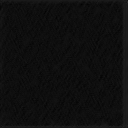

In [19]:
display(im_reconstruct)

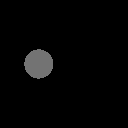

In [20]:
display(im_frame)